In [1]:
# default_exp area_zonal_stats

In [2]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq git+https://github.com/thinkingmachines/geowrangler.git

In [3]:
# hide
# no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [4]:
# hide
# no_test
!mkdir -p ../data
# download sample geojson files from repo

In [5]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
# hide
import warnings

from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings(action="ignore", category=UserWarning, module="geopandas")
warnings.filterwarnings(
    action="ignore", category=ShapelyDeprecationWarning, module="pandas"
)

# Area Zonal Stats

> generate vector zonal stat features for area data

In [7]:
# export
from typing import Any, Dict, List

import geopandas as gpd
import numpy as np
import geowrangler.vector_zonal_stats as vzs
from geowrangler.vector_zonal_stats import GEO_INDEX_NAME

In [8]:
# hide
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

In [9]:
# exporti
def extract_func(func):
    extra = []
    if func.__contains__("raw_"):
        extra += ["raw"]
        func = func.replace("raw_", "")
    if func.__contains__("imputed_"):
        extra += ["imputed"]
        func = func.replace("imputed_", "")
    return func, extra

In [10]:
# hide
assert extract_func("count") == ("count", [])
assert extract_func("raw_count") == ("count", ["raw"])
assert extract_func("imputed_count") == ("count", ["imputed"])
assert extract_func("raw_imputed_count") == ("count", ["raw", "imputed"])

In [11]:
# exporti


def fix_area_agg(agg):
    if "func" not in agg:
        return agg  # skip fix as agg spec is invalid

    if type(agg["func"]) == str:
        agg["func"] = [agg["func"]]

    real_funcs = []
    func_extras = []
    for func in agg["func"]:
        real_func, extra = extract_func(func)
        real_funcs += [real_func]
        func_extras += [extra]
    agg["func"] = real_funcs
    agg["extras"] = func_extras

    agg = vzs._fix_agg(agg)

    return agg

In [12]:
# hide
assert fix_area_agg(dict(func="count")) == dict(
    func=["count"],
    column=GEO_INDEX_NAME,
    output=["index_count"],
    fillna=[False],
    extras=[[]],
)

In [13]:
# hide
assert fix_area_agg(
    dict(
        func=["count", "sum"],
        column="population",
        output=["samples", "population"],
        fillna=[True, True],
    )
) == dict(
    func=["count", "sum"],
    column="population",
    output=["samples", "population"],
    fillna=[True, True],
    extras=[[], []],
)

In [14]:
# exporti


def get_source_column(agg):

    if "raw" in agg["extras"]:
        return agg["column"]  # dont use intersect column

    intersect_data_column = f"intersect_data_{agg['column']}"
    intersect_aoi_column = f"intersect_aoi_{agg['column']}"

    if agg["func"] in ("sum", "count"):
        return intersect_data_column

    return intersect_aoi_column

In [15]:
# hide
assert (
    get_source_column(dict(func="count", column="population", extras=[]))
    == "intersect_data_population"
)
assert (
    get_source_column(dict(func="count", column="population", extras=["raw"]))
    == "population"
)
assert (
    get_source_column(dict(func="sum", column="population", extras=[]))
    == "intersect_data_population"
)
assert (
    get_source_column(dict(func="mean", column="population", extras=[]))
    == "intersect_aoi_population"
)
assert (
    get_source_column(dict(func="mean", column="population", extras=["raw"]))
    == "population"
)

In [16]:
# exporti
INTERSECT_AREA_AGG = {
    "column": "intersect_area",
    "func": "sum",
    "output": "intersect_area_sum",
    "extras": "raw",
}

In [17]:
# exporti
def build_agg_area_dicts(aggs):
    aggs = [INTERSECT_AREA_AGG, *aggs]
    agg_dicts = {agg["output"]: (get_source_column(agg), agg["func"]) for agg in aggs}
    return agg_dicts

In [18]:
# hide
input_aggs = [
    {
        "column": GEO_INDEX_NAME,
        "func": "count",
        "output": f"{GEO_INDEX_NAME}_count",
        "extras": ["raw"],
    },
    {"column": "population", "func": "sum", "output": "population_sum", "extras": []},
    {
        "column": "internet_speed",
        "func": "mean",
        "output": "internet_speed_mean",
        "extras": [],
    },
    {
        "column": "internet_speed",
        "func": "mean",
        "output": "internet_speed_imputed_mean",
        "extras": [
            "imputed",
        ],
    },
]

In [19]:
# hide
assert build_agg_area_dicts(input_aggs) == {
    f"{GEO_INDEX_NAME}_count": (f"{GEO_INDEX_NAME}", "count"),
    "intersect_area_sum": ("intersect_area", "sum"),
    "population_sum": ("intersect_data_population", "sum"),
    "internet_speed_mean": ("intersect_aoi_internet_speed", "mean"),
    "internet_speed_imputed_mean": ("intersect_aoi_internet_speed", "mean"),
}

In [20]:
# exporti


def validate_area_aoi(aoi):
    if aoi.crs.is_geographic:
        raise ValueError(
            f"aoi has geographic crs: {aoi.crs}, areas maybe incorrectly computed"
        )

In [21]:
# exporti


def validate_area_data(data):
    if data.crs.is_geographic:
        raise ValueError(
            f"data has geographic crs: {data.crs}, areas maybe incorrectly computed"
        )

In [22]:
# exporti


def expand_area_aggs(aggs):
    expanded_aggs = []
    for agg in aggs:
        for i, func in enumerate(agg["func"]):
            expanded_agg = {
                "func": func,
                "column": agg["column"],
                "output": agg["output"][i],
                "fillna": agg["fillna"][i],
                "extras": agg["extras"][i],
            }
            expanded_aggs += [expanded_agg]
    return expanded_aggs

In [23]:
# exporti
def compute_intersect_stats(intersect, expanded_aggs):
    # optimization - use df.apply to create all new columns simultaneously
    for agg in expanded_aggs:
        if "raw" in agg["extras"]:
            pass  # dont use intersect stat
        intersect_data_column = f"intersect_data_{agg['column']}"
        intersect_aoi_column = f"intersect_aoi_{agg['column']}"
        if intersect_data_column not in intersect.columns.values:
            intersect[intersect_data_column] = (
                intersect["pct_data"] * intersect[agg["column"]]
            )
        if intersect_aoi_column not in intersect.columns.values:
            intersect[intersect_aoi_column] = (
                intersect["pct_aoi"] * intersect[agg["column"]]
            )
    return intersect

In [24]:
# exporti
def compute_imputed_stats(results, expanded_aggs):
    # optimize with df.apply
    # handle when intersect_area_sum is np.nan
    for agg in expanded_aggs:
        if "imputed" in agg["extras"]:
            results[agg["output"]] = (
                results[agg["output"]] / results[INTERSECT_AREA_AGG["output"]]
            )

In [25]:
# export
def create_area_zonal_stats(
    aoi: gpd.GeoDataFrame,  # Area of interest for which zonal stats are to be computed for
    data: gpd.GeoDataFrame,  # Source gdf of region/areas containing data to compute zonal stats from
    aggregations: List[  # List of agg specs, with each agg spec applied to a data column
        Dict[str, Any]
    ],
    include_intersect=True,  # Add column 'intersect_area_sum' w/ch computes total area of data areas intersecting aoi
    fix_min=True,  # Set min to zero if there are areas in aoi w/ch do not containing any intersecting area from the data.
):

    validate_area_aoi(aoi)
    validate_area_data(data)

    fixed_aggs = [fix_area_agg(agg) for agg in aggregations]

    # validate_area_aggs(fixed_aggs,data)
    vzs._validate_aggs(fixed_aggs, data)

    # reindex aoi
    aoi_index_name = aoi.index.name
    aoi = vzs._prep_aoi(aoi)
    data = data.copy()

    if not data.crs.equals(aoi.crs):
        data = data.to_crs(aoi.crs)

    # compute aoi and data areas
    aoi["aoi_area"] = aoi.geometry.area
    data["data_area"] = data.geometry.area

    # add spatial indexes
    aoi.geometry.sindex
    data.geometry.sindex

    intersect = aoi.overlay(data, keep_geom_type=True)

    # compute intersect area and percentages
    intersect["intersect_area"] = intersect.geometry.area
    intersect["pct_data"] = intersect["intersect_area"] / intersect["data_area"]
    intersect["pct_aoi"] = intersect["intersect_area"] / intersect["aoi_area"]

    expanded_aggs = expand_area_aggs(fixed_aggs)
    intersect = compute_intersect_stats(intersect, expanded_aggs)

    groups = intersect.groupby(GEO_INDEX_NAME)

    agg_area_dicts = build_agg_area_dicts(expanded_aggs)

    aggregates = groups.agg(**agg_area_dicts)

    results = aoi.merge(
        aggregates, how="left", on=GEO_INDEX_NAME, suffixes=(None, "_y")
    )

    # set min to zero if intersect area is not filled.
    if fix_min:
        for col, val in agg_area_dicts.items():
            if val[1] == "min":
                results[col] = results.apply(
                    lambda x, c: x[c]
                    if np.isclose(x["aoi_area"], x["intersect_area_sum"])
                    else 0.0,
                    axis=1,
                    c=col,  # kwarg to pass to lambda
                )

    compute_imputed_stats(results, expanded_aggs)
    drop_labels = ["aoi_area"]
    if not include_intersect:
        drop_labels += [INTERSECT_AREA_AGG["output"]]
    results.drop(labels=drop_labels, inplace=True, axis=1)

    results.set_index(GEO_INDEX_NAME, inplace=True)
    results.index.name = aoi_index_name
    return results

## Test data

### Simple squares

In [26]:
# hide
def square(x, y, size=1):
    return Polygon([(x, y), (x, size + y), (size + x, size + y), (size + x, y)])

In [27]:
# hide
def make_df(
    xsize,
    ysize,
    has_internet=True,
    has_population=True,
    size=1,
    offset_x=0.25,
    offset_y=0.0,
    pop_x_factor=100,
    pop_y_factor=0,
    internet_base_speed=20.0,
    internet_x_exp=2.0,
    internet_y_factor=100,
    crs="EPSG:3857",
):
    d = dict(
        geometry=[
            square(x + offset_x, y + offset_y)
            for x in range(xsize)
            for y in range(ysize)
        ]
    )
    if has_population:
        d["population"] = [
            pop_x_factor * (x + 1) + y * (pop_x_factor * ysize + pop_y_factor)
            for x in range(xsize)
            for y in range(ysize)
        ]
    if has_internet:
        d["internet_speed"] = [
            internet_base_speed / (internet_x_exp**x) + internet_y_factor * y
            for x in range(xsize)
            for y in range(ysize)
        ]
    return gpd.GeoDataFrame(d, crs=crs)

In [28]:
# hide
simple_aoi = make_df(3, 1, has_internet=False, has_population=False, offset_x=0.0)
simple_data = make_df(3, 1)

Given an aoi (`simple_aoi`) and geodataframe containing sample data (`simple_data`)

In [29]:
simple_aoi

,geometry
0,"POLYGON ((0.000 0.000, 0.000 1.000, 1.000 1.00..."
1,"POLYGON ((1.000 0.000, 1.000 1.000, 2.000 1.00..."
2,"POLYGON ((2.000 0.000, 2.000 1.000, 3.000 1.00..."


In [30]:
simple_data

,geometry,population,internet_speed
0,"POLYGON ((0.250 0.000, 0.250 1.000, 1.250 1.00...",100,20.0
1,"POLYGON ((1.250 0.000, 1.250 1.000, 2.250 1.00...",200,10.0
2,"POLYGON ((2.250 0.000, 2.250 1.000, 3.250 1.00...",300,5.0


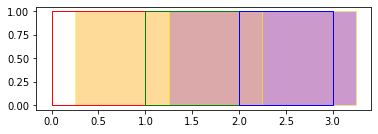

In [31]:
ax = plt.axes()
ax = simple_data.plot(
    ax=ax, color=["orange", "brown", "purple"], edgecolor="yellow", alpha=0.4
)
ax = simple_aoi.plot(ax=ax, facecolor="none", edgecolor=["r", "g", "b"])

The red,green,blue outlines are the 3 regions of interest (aoi) while the orange,brown, purple areas are the data areas. 

In [32]:
%%time
simple_aoi_results = create_area_zonal_stats(
    simple_aoi,
    simple_data,
    [
        dict(func=["sum", "count"], column="population"),
        dict(func=["mean", "max", "min", "std"], column="internet_speed"),
    ],
)

CPU times: user 72.7 ms, sys: 259 µs, total: 73 ms
Wall time: 69.7 ms


In [33]:
simple_aoi_results

,geometry,intersect_area_sum,population_sum,population_count,internet_speed_mean,internet_speed_max,internet_speed_min,internet_speed_std
0,"POLYGON ((0.000 0.000, 0.000 1.000, 1.000 1.00...",0.75,75.0,1,15.000,15.00,0.0,NaN
1,"POLYGON ((1.000 0.000, 1.000 1.000, 2.000 1.00...",1.00,175.0,2,6.250,7.50,5.0,1.767767
2,"POLYGON ((2.000 0.000, 2.000 1.000, 3.000 1.00...",1.00,275.0,2,3.125,3.75,2.5,0.883883


In [34]:
simple_aoi_results.population_sum.sum(axis=None)

525.0

In [35]:
%%time
corrected_aoi_results = create_area_zonal_stats(
    simple_aoi,
    simple_data,
    [
        dict(func=["sum", "count"], column="population"),
        dict(
            func=["mean", "imputed_mean", "raw_max", "raw_min", "raw_std"],
            column="internet_speed",
            output=[
                "internet_speed_mean",
                "internet_speed_imputed_mean",
                "internet_speed_max",
                "internet_speed_min",
                "internet_speed_std",
            ],
        ),
    ],
)

CPU times: user 65.2 ms, sys: 1.93 ms, total: 67.1 ms
Wall time: 63.9 ms


In [36]:
corrected_aoi_results

,geometry,intersect_area_sum,population_sum,population_count,internet_speed_mean,internet_speed_imputed_mean,internet_speed_max,internet_speed_min,internet_speed_std
0,"POLYGON ((0.000 0.000, 0.000 1.000, 1.000 1.00...",0.75,75.0,1,15.000,20.000,20.0,0.0,NaN
1,"POLYGON ((1.000 0.000, 1.000 1.000, 2.000 1.00...",1.00,175.0,2,6.250,6.250,20.0,10.0,7.071068
2,"POLYGON ((2.000 0.000, 2.000 1.000, 3.000 1.00...",1.00,275.0,2,3.125,3.125,10.0,5.0,3.535534


### Test on custom admin grids

In [37]:
%%time
# gdf = make_df(300,2000,has_internet=False, has_population=False, offset_x=0.)
region3_admin_grids = gpd.read_file("../data/region3_admin_grids.geojson")
region3_admin_grids = region3_admin_grids.to_crs("EPSG:3857")  # convert to planar

CPU times: user 69.2 ms, sys: 43.3 ms, total: 113 ms
Wall time: 99.9 ms


In [38]:
%%time
phil_pop_bgy_level = gpd.read_file(
    "../../geowrangler/extradata/ph_population_bgy_level.geojson"
)
phil_pop_bgy_level = phil_pop_bgy_level.to_crs("EPSG:3857")  # convert to planar

CPU times: user 4.07 s, sys: 59.3 ms, total: 4.13 s
Wall time: 4.09 s


In [39]:
%%time
aoi_result = create_area_zonal_stats(
    region3_admin_grids,
    phil_pop_bgy_level,
    [
        dict(func=["sum", "count"], column="population"),
    ],
)

CPU times: user 1.38 s, sys: 0 ns, total: 1.38 s
Wall time: 1.38 s


In [40]:
aoi_result

,x,y,geometry,intersect_area_sum,population_sum,population_count
0,0,30,"POLYGON ((13334497.956 1771012.807, 13339497.9...",1.213773e+06,687.832840,1
1,0,31,"POLYGON ((13334497.956 1776012.807, 13339497.9...",2.471924e+06,986.890853,1
2,0,32,"POLYGON ((13334497.956 1781012.807, 13339497.9...",2.748813e+06,1097.435840,1
3,1,30,"POLYGON ((13339497.956 1771012.807, 13344497.9...",1.081669e+06,468.368614,2
4,1,32,"POLYGON ((13339497.956 1781012.807, 13344497.9...",8.941593e+04,8.570604,2
...,...,...,...,...,...,...
1069,54,44,"POLYGON ((13604497.956 1841012.807, 13609497.9...",1.976718e+05,15.398162,1
1070,54,45,"POLYGON ((13604497.956 1846012.807, 13609497.9...",1.019141e+07,1613.913393,3
1071,54,46,"POLYGON ((13604497.956 1851012.807, 13609497.9...",3.129991e+06,1033.997979,2
1072,54,47,"POLYGON ((13604497.956 1856012.807, 13609497.9...",8.106461e+06,250.893691,2


In [41]:
gdf = region3_admin_grids
gdf2 = phil_pop_bgy_level

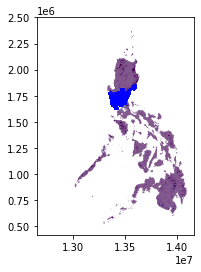

In [42]:
ax = plt.axes()
ax = gdf2.plot(ax=ax, column="population")
ax = gdf.plot(ax=ax, facecolor="none", edgecolor="blue")

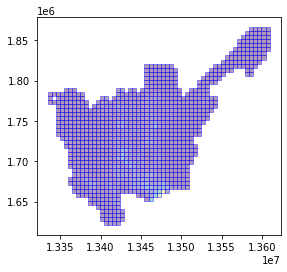

In [43]:
ax = plt.axes()
# ax = gdf2.plot(ax=ax, column='population', alpha=0.4, edgecolor='red')
ax = aoi_result.plot(column="population_sum", ax=ax, alpha=0.4, edgecolor="blue")
# ax = gdf.plot(ax=ax, facecolor="none", edgecolor="blue")

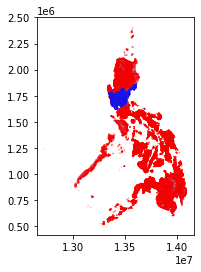

In [44]:
ax = plt.axes()
ax = gdf2.plot(ax=ax, column="population", alpha=0.4, edgecolor="red")
ax = aoi_result.plot(column="intersect_area_sum", ax=ax, alpha=0.4, edgecolor="blue")